In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from glob import glob
import pandas as pd
import pickle
from torch.utils.data import RandomSampler
import random
import scipy
import torch.nn.functional as F
from PIL import Image
from glob import glob
import wandb
import re
from adjustText import adjust_text
import seaborn as sns
import scipy
import statannot

from MedSAM_HCP.utils_hcp import *
from MedSAM_HCP.dataset import *

In [3]:
collector = []
for i in range(7):
    path = f'/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/pooled_labels_ckpt_continue_8-22-23/val_dices_{i}.npy'
    dice_sc = np.load(path)
    collector.append(dice_sc)
    print(dice_sc)

total_merge = np.concatenate(collector, axis=0)
print(np.nanmean(total_merge[:,0]))

df = pd.DataFrame(total_merge, columns = ['dice_score', 'label'])
df['label'] = df['label'].astype('int')
print(df.groupby('label').agg({'dice_score': np.nanmean})['dice_score'].median())
#print(df.groupby('label').agg({'dice_score': np.std})['dice_score'].sort_values())


[[ 0.93513381  1.        ]
 [ 0.89039546  1.        ]
 [ 0.94664615  1.        ]
 ...
 [ 0.89285713 15.        ]
 [ 0.70175439 15.        ]
 [ 0.87719297 15.        ]]
[[ 0.7846154  15.        ]
 [ 0.32098767 15.        ]
 [ 0.61538464 15.        ]
 ...
 [ 0.2857143  34.        ]
 [ 0.4556962  34.        ]
 [ 0.69724768 34.        ]]
[[ 0.72000003 34.        ]
 [ 0.45454547 34.        ]
 [ 0.76543212 34.        ]
 ...
 [ 0.78787881 53.        ]
 [ 0.7266314  53.        ]
 [ 0.81003582 53.        ]]
[[ 0.55371898 53.        ]
 [ 0.79393941 53.        ]
 [ 0.77187949 53.        ]
 ...
 [ 0.84629983 65.        ]
 [ 0.74801064 65.        ]
 [ 0.86052006 65.        ]]
[[ 0.87350833 65.        ]
 [ 0.84263957 65.        ]
 [ 0.85215366 65.        ]
 ...
 [ 0.7751323  78.        ]
 [ 0.79012346 78.        ]
 [ 0.74615383 78.        ]]
[[8.33034098e-01 7.80000000e+01]
 [8.19406986e-01 7.80000000e+01]
 [8.09135377e-01 7.80000000e+01]
 ...
 [4.10958976e-02 9.20000000e+01]
 [8.13186824e-01 9.2000

### Plot Examples

In [ ]:
df_hcp = pd.read_csv('/gpfs/home/kn2347/MedSAM/hcp_mapping_processed.csv')
df_desired = pd.read_csv('/gpfs/home/kn2347/MedSAM/darts_name_class_mapping_processed.csv')
NUM_CLASSES = len(df_desired)
label_converter = LabelConverter(df_hcp, df_desired)

checkpoint = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/pooled_labels_ckpt_continue_8-22-23/model_best_20230822-115028.pth'
device = 'cuda:0'
sam_model = build_sam_vit_b_multiclass(NUM_CLASSES, checkpoint=checkpoint).to(device)
sam_model.eval()


In [10]:
path_df_path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/per_class_isolated_df/yolov7/path_df_pooled_labels_only_with_bbox_yolov7.csv'
full_df = pd.read_csv(path_df_path, index_col=0)
train_test_splits_path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/train_val_test_split.pickle'
dicto = pickle.load(open(train_test_splits_path, 'rb'))
val_ids = dicto['val']
val_df = full_df[full_df['id'].isin(val_ids)].reset_index(drop=True)


#train_dataset, val_dataset, test_dataset = load_datasets(path_df_path, train_test_splits_path, label_id = None, bbox_shift=0, sample_n_slices = None, label_converter= label_converter, NUM_CLASSES=NUM_CLASSES, as_one_hot=True, pool_labels=True)

In [12]:
val_df

,id,slice,image_embedding_slice_path,segmentation_slice_path,image_path,bbox_0,bbox_1,bbox_2,bbox_3,label_number
0,415837,107,/gpfs/data/luilab/karthik/pediatric_seg_proj/h...,/gpfs/data/luilab/karthik/pediatric_seg_proj/h...,/gpfs/data/cbi/hcp/hcp_seg/data_orig/415837/mr...,67,130,187,180,1
1,227533,171,/gpfs/data/luilab/karthik/pediatric_seg_proj/h...,/gpfs/data/luilab/karthik/pediatric_seg_proj/h...,/gpfs/data/cbi/hcp/hcp_seg/data_orig/227533/mr...,123,145,162,181,1
2,136631,132,/gpfs/data/luilab/karthik/pediatric_seg_proj/h...,/gpfs/data/luilab/karthik/pediatric_seg_proj/h...,/gpfs/data/cbi/hcp/hcp_seg/data_orig/136631/mr...,48,128,202,190,1
3,281135,112,/gpfs/data/luilab/karthik/pediatric_seg_proj/h...,/gpfs/data/luilab/karthik/pediatric_seg_proj/h...,/gpfs/data/cbi/hcp/hcp_seg/data_orig/281135/mr...,62,130,200,188,1
4,729557,152,/gpfs/data/luilab/karthik/pediatric_seg_proj/h...,/gpfs/data/luilab/karthik/pediatric_seg_proj/h...,/gpfs/data/cbi/hcp/hcp_seg/data_orig/729557/mr...,54,127,206,183,1
...,...,...,...,...,...,...,...,...,...,...
392422,154532,141,/gpfs/data/luilab/karthik/pediatric_seg_proj/h...,/gpfs/data/luilab/karthik/pediatric_seg_proj/h...,/gpfs/data/cbi/hcp/hcp_seg/data_orig/154532/mr...,121,88,170,103,102
392423,513736,133,/gpfs/data/luilab/karthik/pediatric_seg_proj/h...,/gpfs/data/luilab/karthik/pediatric_seg_proj/h...,/gpfs/data/cbi/hcp/hcp_seg/data_orig/513736/mr...,121,87,145,95,102
392424,102109,162,/gpfs/data/luilab/karthik/pediatric_seg_proj/h...,/gpfs/data/luilab/karthik/pediatric_seg_proj/h...,/gpfs/data/cbi/hcp/hcp_seg/data_orig/102109/mr...,143,89,161,118,102
392425,453441,146,/gpfs/data/luilab/karthik/pediatric_seg_proj/h...,/gpfs/data/luilab/karthik/pediatric_seg_proj/h...,/gpfs/data/cbi/hcp/hcp_seg/data_orig/453441/mr...,129,86,170,102,102


100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


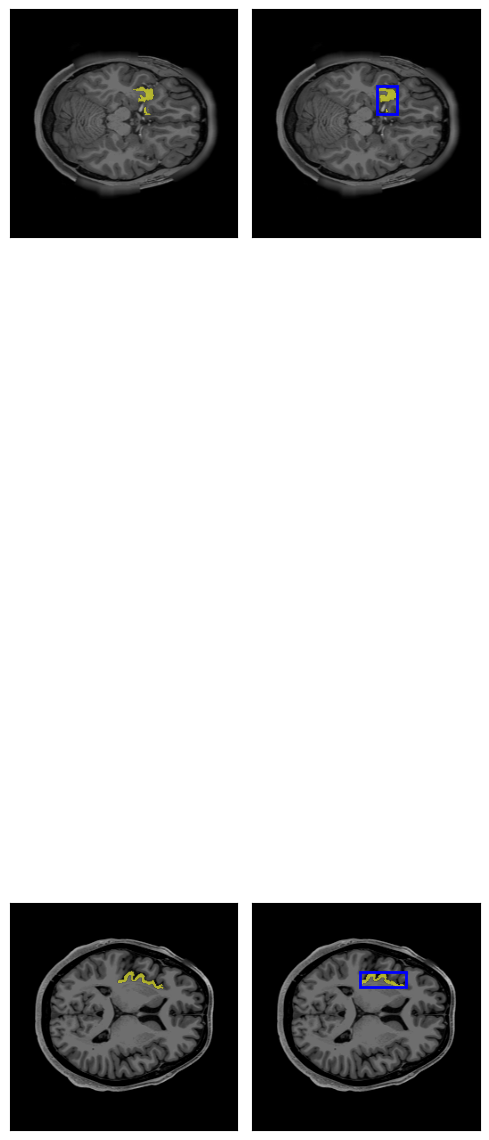

In [55]:
def plot_random_for_label(label, to_plot=5, seed = 2023):
    this_df = val_df.copy()
    this_df = this_df[this_df.label_number == label]

    np.random.seed(seed)
    fig, axs = plt.subplots(to_plot, 2, figsize = (5,25))

    rand_idx_df = this_df.sample(n=to_plot, replace=False, random_state=seed,
                axis=0, ignore_index=True)

    # create dataset
    ds = MRIDataset(rand_idx_df, label, bbox_shift=0, label_converter = label_converter, NUM_CLASSES=NUM_CLASSES, as_one_hot=True, pool_labels=False)

    # create datalaoder
    batch_sz = 1
    dataloader = DataLoader(
            ds,
            batch_size = batch_sz,
            shuffle = False,
            num_workers = 4,
            pin_memory = True)

    for step, (image_embedding, gt2D, boxes, slice_names) in enumerate(tqdm(dataloader)):
        image_embedding, gt2D, boxes = image_embedding.cuda(), gt2D.cuda(), boxes.cuda()
        # ground truth
        
        axs[step,0].imshow(np.repeat(ds.load_image(step)[:,:,None],3,axis=-1))
        show_mask(gt2D[0,0,:,:].cpu().detach().numpy()>0, axs[step, 0])
        axs[step,0].grid(False)
        axs[step,1].grid(False)
        axs[step,0].set_xticks([])
        axs[step,0].set_yticks([])
        axs[step,1].set_xticks([])
        axs[step,1].set_yticks([])

        pred = medsam_inference(sam_model, image_embedding, boxes, 256, 256, as_one_hot=True, model_trained_on_multi_label=False)
        pred = pred[0,0,:,:].astype('uint8') * 255

        axs[step,1].imshow(np.repeat(ds.load_image(step)[:,:,None],3,axis=-1))
        show_mask(pred>0, axs[step, 1])
        show_box(boxes.flatten().cpu().numpy(), axs[step, 1])
        #axs[step,1].imshow(np.repeat(pred[:,:,None], 3, axis=-1))
    fig.tight_layout()

        

    return
plot_random_for_label(102, to_plot=2, seed=2023)